In [1]:
#This notebook will import a touchstone file and display insertion loss graph.
import pandas as pd
import numpy as np
import matplotlib as plt
import math
import cmath

# Set the path of the raw .s4p file in the same directory as this notebook
file_path = "<data>.s4p"

# This section here is used to read the first 100 rows of the file above as text and 
# parse through each line to find the "#" symbol signifying the start of the data. 
# This can be used to set the number of "skip rows" for read_csv below. We can also pull the information from this
# line to show what the units and format of the data are. For example if row number 24 is "#Hz S dB R 50" then 
# we would set skip_rows = 24, SI_units = "dB", number_type = "real", tester_impedance = "50"

with open(file_path, "r") as file1:
    # Search through the first 100 rows of the file
    for i in range(0, 100):
        # Assign the entire row to a string variable for slicing
        one_line = file1.readline()
        # Search the first character in each successive line for the "#" symbol indicating the key row
        if (one_line[0] == "#"):
            # Set the skip row number for use in the read_csv method later on
            skip_rows = i
            # Set a string variable to the skip row containing the units, number type, and impedance for later use
            key_row = one_line
        
print('The firtst ' + str(skip_rows) + ' rows of the file contain header info and will be skipped.')
print('The s-parameter data is in the format ' + key_row)

The firtst 22 rows of the file contain header info and will be skipped.
The s-parameter data is in the format # Hz S  dB   R 50



In [2]:
# Read in the space delimited file, skipping the rows of header information. 
# The skip_rows is + 1 because of indexing.
df_raw = pd.read_csv(file_path, skiprows = skip_rows + 1, delim_whitespace = True, header = None)

df_raw.head(5)

,0,1,2,3,4,5,6,7,8
0,1.000000e+07,-18.596588,25.395187,-0.829325,-18.962502,-20.599869,20.452127,-22.130384,167.08244
1,-8.246641e-01,-18.926477,-19.969500,14.719769,-22.138124,167.045780,-21.730087,6.246666,NaN
2,-2.057517e+01,20.198177,-22.130781,166.885910,-18.240007,27.106436,-0.820171,-18.926466,NaN
3,-2.211367e+01,167.374400,-21.719362,6.261957,-0.831857,-18.954756,-19.607506,17.418802,NaN
4,2.000000e+07,-15.933050,23.195728,-0.907085,-36.680450,-18.317211,22.228508,-22.045498,148.03929


The s4p data comes in an odd format. Each fourth line has 9 elements while the other 3 have 8.  We want to move the 8 elements on line 2,3, and 4 for each group to line up with elements 2-9 in line 1. The empty space left by this move will be filled by null values.

In the loop below we will parse through and reassign every element to an appropriate location in a clean matrix. The new matrix will contain the test frequency in the first column, and the S-parameters in the following 32 columns in the format....
  
Freq S11_db S11_ang S12_db S12_ang S13_db S13_ang S14_db S14_ang S21_db S21_ang ... S44_db S44_ang

In [3]:
# Make an empty df of the correct size order to replace each index. 
# Note how we divide the rows by 4 and increase the columns to 32. This is because we are moving
# all the parameters for each frequency onto one row
df_clean = pd.DataFrame(np.nan, index = range(int(df_raw.shape[0]/4)), columns = range(33))

# Create a column counting variable to transform the 4x8 data formation for each frequency into 1x32. Set to 0 to start
col_count = -1
# Create a row counting varible to help assign each of the values from rows 2, 3, and 4 of each set to the one row.
# It is set to -1 here because it gets incremented prior to each new row including the first run through
row_count = -1
# Parse through each row
for row in range(df_raw.shape[0]):
    # Parse through each column
    for col in range(df_raw.shape[1]):
        # Set a boolean value to True if it is the 1st, 5th, 9th, etc. line with 9 elements.
        fourth_row = ((row + 1) % 4 == 1)
        # Set a boolean value to True if it is the 1st column.
        first_col = (col == 0)
        # Check if the value is empty
        isnan = math.isnan(df_raw.iloc[row, col])
        
        if (fourth_row and first_col):
            # Increment the row count
            row_count += 1
            # Reset the column count
            col_count = 0
            # Assign the test frequency to the first column. This is only run on the first of every
            # four rows. 
            df_clean.iloc[row_count, 0] = df_raw.iloc[row, col]
            
        elif (not(isnan)):
            # increment the column count by 1
            col_count += 1
            # Asign the corresponding value in the raw df to the clean df
            df_clean.iloc[row_count, col_count] = df_raw.iloc[row, col]
            
df_clean.head(5)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,10000000.0,-18.596588,25.395187,-0.829325,-18.962502,-20.599869,20.452127,-22.130384,167.082440,-0.824664,...,-0.820171,-18.926466,-22.113672,167.374400,-21.719362,6.261957,-0.831857,-18.954756,-19.607506,17.418802
1,20000000.0,-15.933050,23.195728,-0.907085,-36.680450,-18.317211,22.228508,-22.045498,148.039290,-0.894979,...,-0.905958,-36.740604,-22.017279,148.079270,-21.319891,5.571363,-0.915962,-36.726948,-17.741117,15.174589
2,30000000.0,-14.164801,15.447616,-0.949940,-54.491714,-16.506487,16.863007,-21.879795,129.671130,-0.939659,...,-0.957559,-54.528019,-21.867096,129.630540,-20.785999,4.103856,-0.967593,-54.527195,-16.454571,9.387960
3,40000000.0,-13.137456,4.981560,-0.983946,-72.260612,-15.400001,8.126373,-21.774549,110.583340,-0.973613,...,-1.005550,-72.242943,-21.759212,110.589640,-20.369322,1.309860,-1.015330,-72.231308,-15.687264,1.226964
4,50000000.0,-12.790644,-6.411620,-1.010984,-90.023483,-14.905635,-2.051344,-21.770765,91.741684,-1.002662,...,-1.031587,-89.926414,-21.753599,91.764519,-20.100000,-2.939586,-1.038548,-89.924919,-15.469161,-7.984244


In [4]:
# Split the data into two data frames, one for magnitude and the other for angle

# Pull the column of frequencies out of the clean df
frequencies = df_clean[0]

# Pull in the freq col for each
df_Mag_single = frequencies
df_Ang_single = frequencies

# Every other col starting with 1, must be cast as a list to pass as a filter
mag_indices = list(range(1, df_clean.shape[1], 2))
# Every other col starting with 2
ang_indices = list(range(2, df_clean.shape[1], 2))

# Concatanate the columns from the existing clean df into the new separated mag and ang
df_Mag_single = pd.concat([df_Mag_single, df_clean[mag_indices]], axis = 1)
df_Ang_single = pd.concat([df_Ang_single, df_clean[ang_indices]], axis = 1)

df_Mag_single.head()

,0,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31
0,10000000.0,-18.596588,-0.829325,-20.599869,-22.130384,-0.824664,-19.969500,-22.138124,-21.730087,-20.575172,-22.130781,-18.240007,-0.820171,-22.113672,-21.719362,-0.831857,-19.607506
1,20000000.0,-15.933050,-0.907085,-18.317211,-22.045498,-0.894979,-18.318392,-22.075417,-21.316929,-18.289541,-22.057865,-15.512713,-0.905958,-22.017279,-21.319891,-0.915962,-17.741117
2,30000000.0,-14.164801,-0.949940,-16.506487,-21.879795,-0.939659,-17.243998,-21.932217,-20.788912,-16.478098,-21.926128,-13.640087,-0.957559,-21.867096,-20.785999,-0.967593,-16.454571
3,40000000.0,-13.137456,-0.983946,-15.400001,-21.774549,-0.973613,-16.678892,-21.867680,-20.356461,-15.380406,-21.851370,-12.526717,-1.005550,-21.759212,-20.369322,-1.015330,-15.687264
4,50000000.0,-12.790644,-1.010984,-14.905635,-21.770765,-1.002662,-16.606049,-21.882706,-20.084230,-14.885537,-21.875149,-12.120833,-1.031587,-21.753599,-20.100000,-1.038548,-15.469161


In [5]:
# Create variables for the number of total rows and the number of columns to use for creating df's

total_rows = frequencies.shape[0]
total_cols = df_Mag_single.shape[1]

In [6]:
# A dictoinary of the coefficents for each conversion expression are created and grouped
# by parameter
coefs = {'SDD':[1, -1, -1, 1], 'SDC':[1, -1, 1, -1], 'SCD':[1, 1, -1, -1], 'SCC':[1, 1, 1, 1]}

# A dictionary of the parameters to be pulled for each row of every group is created. We will use
# this to help pull the correct parameters from s and sj above
param = {'11':['S11', 'S31', 'S13', 'S33'], '12':['S12', 'S32', 'S14', 'S34'],
         '21':['S21', 'S41', 'S23', 'S43'], '22':['S22', 'S42', 'S24', 'S44']}

# Create new list for column headers in the SCD, SDD format
s = ['freq']
# Step through each key in the coefs dictionary ie. 'SDD', 'SDC', etc.
for key_coef in coefs:
    # Step throught each key in the ordered Single Ended Parameters dictionary ie. '11', '12', etc.
    for key_param in param:
        s.append(key_coef + key_param)
        
# Create new list for column headers in the SCD, SDD format
s_temp = ['freq']
# Step through each key in the coefs dictionary ie. 'SDD', 'SDC', etc.
for i in range(1, 5):
    # Step throught each key in the ordered Single Ended Parameters dictionary ie. '11', '12', etc.
    for j in range(1, 5):
        s_temp.append('S' + str(i) + str(j))

In [7]:
# Rename the column headers for the single ended magnitude and angle df's

# Reassign headers
df_Mag_single.columns = s
df_Ang_single.columns = s

df_Ang_single.head(5)

,freq,SDD11,SDD12,SDD21,SDD22,SDC11,SDC12,SDC21,SDC22,SCD11,SCD12,SCD21,SCD22,SCC11,SCC12,SCC21,SCC22
0,10000000.0,25.395187,-18.962502,20.452127,167.082440,-18.926477,14.719769,167.045780,6.246666,20.198177,166.885910,27.106436,-18.926466,167.374400,6.261957,-18.954756,17.418802
1,20000000.0,23.195728,-36.680450,22.228508,148.039290,-36.679436,12.131729,147.892270,5.653028,22.242695,147.862060,24.817228,-36.740604,148.079270,5.571363,-36.726948,15.174589
2,30000000.0,15.447616,-54.491714,16.863007,129.671130,-54.502537,6.663044,129.327580,4.192590,16.857693,129.396240,17.082306,-54.528019,129.630540,4.103856,-54.527195,9.387960
3,40000000.0,4.981560,-72.260612,8.126373,110.583340,-72.278091,-0.804424,110.413030,1.278830,8.071189,110.396150,6.222650,-72.242943,110.589640,1.309860,-72.231308,1.226964
4,50000000.0,-6.411620,-90.023483,-2.051344,91.741684,-90.027786,-8.733941,91.700073,-2.940102,-2.031234,91.666107,-5.617762,-89.926414,91.764519,-2.939586,-89.924919,-7.984244


In [8]:
# Create an equivalent df of real and imaginary numbers

##ERROR need to not use the whole df here or go back and reassign frequencies as indices
# Convert them to base 10 magnitudes
# magnitude = 10^(<db>/20)
for col in range(1, total_cols):
    df_Mag_single.iloc[:,col] = 10**(df_Mag_single.iloc[:, col]/20)

df_Real_single = pd.DataFrame(np.nan, index = range(total_rows), columns = s)
df_Imag_single = pd.DataFrame(np.nan, index = range(total_rows), columns = s)
df_Real_single['freq'] = frequencies
df_Imag_single['freq'] = frequencies

# Iterate through each column
for col in range(1,total_cols):
    # Every row
    for row in range(total_rows):
        # Convert the magnitude and angle to a complex object
        real_imag = cmath.rect(df_Mag_single.iloc[row,col], df_Ang_single.iloc[row, col])
        # Store the real coefficient in the real df
        df_Real_single.iloc[row, col] = real_imag.real
        # Store the imaginary coefficent in the imaginary df
        df_Imag_single.iloc[row, col] = real_imag.imag
        
# Preview the data frame
print(df_Real_single.head(5))
print(df_Imag_single.head(5))
            

         freq     SDD11     SDD12     SDD21     SDD22     SDC11     SDC12  \
0  10000000.0  0.113511  0.903145 -0.002965 -0.065537  0.906736 -0.055213   
1  20000000.0 -0.057192  0.472494 -0.117975 -0.073250  0.472374  0.110077   
2  30000000.0 -0.189179 -0.418828 -0.060385 -0.052190 -0.410712  0.127551   
3  40000000.0  0.058600 -0.892893 -0.045689 -0.065987 -0.893757  0.101653   
4  50000000.0  0.227445 -0.417417 -0.083102 -0.065635 -0.421199 -0.113917   

      SDC21     SDC22     SCD11     SCD12     SCD21     SCD22     SCC11  \
0 -0.067000  0.081885  0.020623 -0.072620 -0.048015  0.907206 -0.050555   
1 -0.076537  0.069427 -0.117933 -0.077218  0.159360  0.517815 -0.072242   
2 -0.069382 -0.045358 -0.061311 -0.066526 -0.040594 -0.389443 -0.054716   
3 -0.072365  0.027626 -0.036680 -0.073093  0.235976 -0.890598 -0.065800   
4 -0.066727 -0.097031 -0.080064 -0.068278  0.194869 -0.338454 -0.064640   

      SCC12     SCC21     SCC22  
0  0.082023  0.903648  0.014604  
1  0.065043  0.507

In [9]:
# Now we can convert from single ended to mixed mode
            
# Create two data frames full of 0's of equivalent size to store the results in
df_Real_mixed = pd.DataFrame(0, index = range(total_rows), columns = s)
df_Imag_mixed = pd.DataFrame(0, index = range(total_rows), columns = s)

# Reasigne column headers for use in conversion below
df_Real_single.columns = s_temp
df_Imag_single.columns = s_temp

chk_str = ''
for row in range(total_rows):
    if row == 0:
        print("Below is the matrix we use to transform the single ended parameters to mixed mode.")
    # Step through each key in the coefs dictionary ie. 'SDD', 'SDC', etc.
    for key_coef in coefs:
        # Print a blank row between the groups of the matrix to be displayed.
        if row == 0:
            print('')
        # Step throught each key in the ordered Single Ended Parameters dictionary ie. '11', '12', etc.
        for key_param in param:
            # Step through each of the values in the param and coefs
            for i in range(4):
                # This creates a column name to call into the single ended parameter 
                col = key_coef + key_param
                # Calculate each new mixed mode parameter by mulitplying the coefficent, a +1 or -1, and 
                # mulitply by the corresponding parameter from the single ended df and add onto the mixed mode.
                df_Real_mixed.loc[row, col] = df_Real_mixed.loc[row, col] + 0.5 * coefs[key_coef][i] * df_Real_single.loc[row, str(param[key_param][i])]
                df_Imag_mixed.loc[row, col] = df_Imag_mixed.loc[row, col] + 0.5 * coefs[key_coef][i] * df_Imag_single.loc[row, str(param[key_param][i])]
                # We will check our coefficient progression on the first run through to make sure we are creating
                # the correct equations.
                if row == 0:
                    # Concatenate the coeficint and variable name to the check string
                    chk_str += str(coefs[key_coef][i]) + ' * ' + str(param[key_param][i]) + " + "
                    # On 4th round
                    if i == 3:
                        # Drop the final " + "
                        chk_str = chk_str[:-3]
                        # Print summary of each calculation to check
                        print(str(key_coef) + str(key_param) + " = 1/2 * (" + chk_str + ')')
                        # Clear the check string
                        chk_str = ''

df_Real_mixed.head(5)

Below is the matrix we use to transform the single ended parameters to mixed mode.

SDD11 = 1/2 * (1 * S11 + -1 * S31 + -1 * S13 + 1 * S33)
SDD12 = 1/2 * (1 * S12 + -1 * S32 + -1 * S14 + 1 * S34)
SDD21 = 1/2 * (1 * S21 + -1 * S41 + -1 * S23 + 1 * S43)
SDD22 = 1/2 * (1 * S22 + -1 * S42 + -1 * S24 + 1 * S44)

SDC11 = 1/2 * (1 * S11 + -1 * S31 + 1 * S13 + -1 * S33)
SDC12 = 1/2 * (1 * S12 + -1 * S32 + 1 * S14 + -1 * S34)
SDC21 = 1/2 * (1 * S21 + -1 * S41 + 1 * S23 + -1 * S43)
SDC22 = 1/2 * (1 * S22 + -1 * S42 + 1 * S24 + -1 * S44)

SCD11 = 1/2 * (1 * S11 + 1 * S31 + -1 * S13 + -1 * S33)
SCD12 = 1/2 * (1 * S12 + 1 * S32 + -1 * S14 + -1 * S34)
SCD21 = 1/2 * (1 * S21 + 1 * S41 + -1 * S23 + -1 * S43)
SCD22 = 1/2 * (1 * S22 + 1 * S42 + -1 * S24 + -1 * S44)

SCC11 = 1/2 * (1 * S11 + 1 * S31 + 1 * S13 + 1 * S33)
SCC12 = 1/2 * (1 * S12 + 1 * S32 + 1 * S14 + 1 * S34)
SCC21 = 1/2 * (1 * S21 + 1 * S41 + 1 * S23 + 1 * S43)
SCC22 = 1/2 * (1 * S22 + 1 * S42 + 1 * S24 + 1 * S44)


,freq,SDD11,SDD12,SDD21,SDD22,SDC11,SDC12,SDC21,SDC22,SCD11,SCD12,SCD21,SCD22,SCC11,SCC12,SCC21,SCC22
0,0,0.023919,0.974254,0.963970,-0.102259,0.068969,0.001512,-0.006679,-0.034977,0.092558,-0.005572,0.009766,-0.034840,0.041577,0.836097,0.846414,0.061649
1,0,0.169038,0.570388,0.564134,-0.068039,-0.108297,-0.020677,-0.019518,0.113073,-0.108255,-0.024644,-0.015223,0.108689,-0.066870,0.419920,0.415355,0.066431
2,0,-0.054039,-0.344778,-0.338135,0.037412,-0.073829,-0.007525,-0.017860,0.142360,-0.074756,-0.021860,-0.003194,0.135497,-0.175734,-0.463494,-0.462234,-0.060167
3,0,0.188473,-0.822205,-0.822493,0.052343,-0.093192,0.002406,-0.005464,0.024585,-0.084184,-0.004700,0.001101,0.021683,0.106104,-0.961286,-0.960658,0.104694
4,0,0.292740,-0.310979,-0.313394,0.029037,0.014769,-0.038160,-0.043165,-0.046110,0.017806,-0.040803,-0.041079,-0.045923,0.129574,-0.444892,-0.444761,-0.164839


In [10]:
# Convert back to magnitude and angle

# Create two data frames full of 0's of equivalent size to store the results in
df_Mag_mixed = pd.DataFrame(0, index = range(total_rows), columns = s)
df_Ang_mixed = pd.DataFrame(0, index = range(total_rows), columns = s)
df_Mag_mixed['freq'] = frequencies
df_Ang_mixed['freq'] = frequencies

# Iterate through each column
for col in range(1,total_cols):
    # Every row
    for row in range(total_rows):
        # Convert the magnitude and angle to a complex object
        mag_ang = cmath.polar(complex(df_Real_mixed.iloc[row,col], df_Imag_mixed.iloc[row, col]))
        # Store the real coefficient in the real df
        df_Mag_mixed.iloc[row, col] = mag_ang[0]
        # Store the imaginary coefficent in the imaginary df
        df_Ang_mixed.iloc[row, col] = mag_ang[1]
        
# Display to check
df_Mag_mixed.head(5)

,freq,SDD11,SDD12,SDD21,SDD22,SDC11,SDC12,SDC21,SDC22,SCD11,SCD12,SCD21,SCD22,SCC11,SCC12,SCC21,SCC22
0,10000000.0,0.031639,0.975549,0.964519,0.102536,0.079773,0.023126,0.023551,0.099428,0.101672,0.010975,0.010201,0.100551,0.169053,0.844968,0.856762,0.062858
1,20000000.0,0.183400,0.962323,0.963889,0.091244,0.118324,0.022224,0.027669,0.126086,0.119009,0.032737,0.016182,0.124765,0.146186,0.841463,0.840235,0.080777
2,30000000.0,0.080786,0.919593,0.915915,0.111780,0.147111,0.017086,0.018847,0.143834,0.147471,0.021903,0.013685,0.137757,0.276617,0.878719,0.882718,0.077515
3,40000000.0,0.336071,0.823030,0.823480,0.085584,0.136973,0.002672,0.027778,0.132773,0.128994,0.015323,0.014517,0.131600,0.117952,0.962361,0.961650,0.156853
4,50000000.0,0.367517,0.819294,0.817884,0.114531,0.091352,0.040857,0.047709,0.058772,0.093867,0.045533,0.043863,0.058617,0.162843,0.958673,0.959779,0.223170


In [11]:
# We want to convert the magnitude back to db to graph it 
for col in range(1, total_cols):
    for row in range(total_rows):
        # Convert them to base 10 magnitudes
        # magnitude = 10^(<db>/20)
        df_Mag_mixed.iloc[row, col] = 20 * math.log10(df_Mag_mixed.iloc[row, col])
    
# Display to check change
df_Mag_mixed.head(5)

,freq,SDD11,SDD12,SDD21,SDD22,SDC11,SDC12,SDC21,SDC22,SCD11,SCD12,SCD21,SCD22,SCC11,SCC12,SCC21,SCC22
0,10000000.0,-29.995431,-0.215022,-0.313784,-19.782473,-21.962876,-32.717977,-32.559962,-20.049837,-19.855980,-39.192228,-39.826904,-19.952231,-15.439528,-1.463194,-1.342795,-24.032817
1,20000000.0,-14.731990,-0.333581,-0.319461,-20.795913,-18.538533,-33.063362,-31.159974,-17.986642,-18.488391,-29.699204,-35.819488,-18.078117,-16.701885,-1.499300,-1.511980,-21.854291
2,30000000.0,-21.853290,-0.728083,-0.762896,-19.032706,-16.647081,-35.346989,-34.495377,-16.842760,-16.625846,-33.190024,-37.275210,-17.217748,-11.162412,-1.123001,-1.083561,-22.212269
3,40000000.0,-9.471370,-1.691684,-1.686936,-21.352105,-17.267322,-51.464040,-31.126011,-17.537778,-17.788601,-36.293192,-36.762737,-17.614856,-18.565912,-0.333243,-0.339660,-16.090154
4,50000000.0,-8.694444,-1.731202,-1.746167,-18.821568,-20.785609,-27.774755,-26.427921,-24.616639,-20.549758,-26.833561,-27.157935,-24.639530,-15.764613,-0.366593,-0.356572,-13.027287


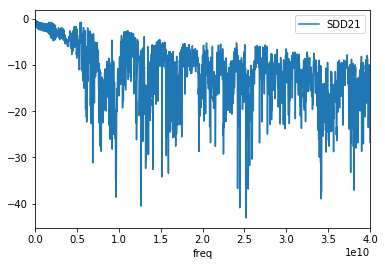

In [12]:
# Allow inline plotting for the notebook
%matplotlib inline

# Create a simple line plot of the data
df_Mag_mixed.plot(x = 'freq', y = 'SDD21', kind = 'line')